# IST 718 Big Data Analytics
## Lab 1 
## Martin Alonso
## 2019-01-26

In [2]:
# Require packages.
import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Data Importation and Cleaning

In [3]:
# Initial data exploration to understand what the data looks like and if we need any additional work before exploring the data. 
coaches = pd.read_csv('Coaches9.csv')

# Print dimension, data type, and first five rows of the data set to understand what we're working with. 
print(coaches.shape)
print(coaches.info())
print(coaches.iloc[0:6])

(129, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 9 columns):
School          129 non-null object
Conference      129 non-null object
Coach           129 non-null object
SchoolPay       129 non-null object
TotalPay        129 non-null object
Bonus           129 non-null object
BonusPaid       129 non-null object
AssistantPay    129 non-null object
Buyout          129 non-null object
dtypes: object(9)
memory usage: 9.1+ KB
None
               School Conference           Coach    SchoolPay     TotalPay  \
0           Air Force   Mt. West    Troy Calhoun       885000       885000   
1                Army       Ind.     Jeff Monken       932521       932521   
2       Brigham Young       Ind.   Kalani Sitake  $2,000,000   $2,000,000    
3                Rice      C-USA  Mike Bloomgren  $1,000,000   $1,000,000    
4  Southern Methodist        AAC     Sonny Dykes  $3,000,000   $3,000,000    
5    Florida Atlantic      C-USA     Lane Kiffin  

From our first analysis of the data, we can see that we are dealing with 9 variables and 129 observations. All variables are classified as objects however, when looking at the data, we can see that most of the numerical data have a dollar sign in front of them. Also, there are missing data like bonuses paid and buyouts.  
Furthermore, it would be ideal if we had a historical record of wins and losses for each coach, each school's graduation date, and stadium size. Additional data such as points scored and points allowed plus games played can also help us determine which teams are more prone to be offense-oriented teams and which ones defense oriented. 

In [4]:
# Check one conference to see how the data is distributed and if there are any variables that need cleaning. 
coaches[coaches['Conference']=='ACC']

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
25,Wake Forest,ACC,Dave Clawson,"$1,831,580","$1,831,580",--,--,$0,--
33,Syracuse,ACC,Dino Babers,"$2,401,206","$2,401,206",--,--,$0,--
36,Boston College,ACC,Steve Addazio,"$2,514,859","$2,514,859",--,--,$0,--
37,Duke,ACC,David Cutcliffe,"$2,540,928","$2,540,928",--,--,$0,--
38,North Carolina,ACC,Larry Fedora,"$2,575,000","$2,575,000","$900,000","$50,000",$0,"$12,215,625"
45,North Carolina State,ACC,Dave Doeren,"$3,000,000","$3,000,000","$1,350,000","$275,000",$0,"$6,125,000"
46,Pittsburgh,ACC,Pat Narduzzi,"$3,017,718","$3,017,718",--,--,$0,--
47,Georgia Tech,ACC,Paul Johnson,"$3,060,018","$3,060,018","$1,330,000","$225,000",$0,"$4,000,000"
55,Virginia,ACC,Bronco Mendenhall,"$3,550,000","$3,550,000","$2,165,000","$75,000",$0,"$18,193,750"
63,Louisville,ACC,Bobby Petrino,"$3,980,434","$3,980,434","$1,472,917","$869,917",$0,"$14,056,250"


Time to clean the data. We'll remove the dollar sign and commas from SchoolPay, TotalPay, Bonus, BonusPaid, AssistantPay, and Buyout. Then, we'll replace -- values with zeroes. 

In [5]:
# Selects all columns that should be numeric.
numColumns = ['SchoolPay', 'TotalPay', 'Bonus', 'BonusPaid', 'AssistantPay', 'Buyout']

# Replaces dollar signs, commas, and hyphens to convert numColumns variables into floats. 
for i in numColumns:
    coaches[i] = coaches[i].replace('[$,]', '', regex=True)
    coaches[i] = coaches[i].replace('[--]', '0', regex=True)
    coaches[i] = coaches[i].astype(float)
     
coaches.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0
1,Army,Ind.,Jeff Monken,932521.0,932521.0,0.0,0.0,0.0,0.0
2,Brigham Young,Ind.,Kalani Sitake,2000000.0,2000000.0,0.0,0.0,0.0,0.0
3,Rice,C-USA,Mike Bloomgren,1000000.0,1000000.0,0.0,0.0,0.0,0.0
4,Southern Methodist,AAC,Sonny Dykes,3000000.0,3000000.0,0.0,0.0,0.0,0.0


Now that the initial data has been cleaned, it is time to import the additional files that have been downloaded and add them to the original data. The files that will be imported have data on each college's rank, record, graduation rate, and stadium capacity.   
Since the data was not cleaned prior to importation, we'll load each comma-separated value file one-by-one. After importing, it will be cleaned and then merged into a single data frame. 

In [6]:
# Load new data sets. 
rank = pd.read_csv('CollegeRank.csv')
records = pd.read_csv('CollegeRecords.csv')
graduation_rate = pd.read_csv('GraduationRates.csv')
stadiums = pd.read_csv('Stadiums.csv')

We'll work on each data set individually. 

In [7]:
# Print initial features of records to understand the data frome. 
print(records.shape)
print(records.info())
print(records.iloc[0:6])

(130, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 8 columns):
Conference    130 non-null object
School        130 non-null object
HomeW         130 non-null int64
HomeL         130 non-null int64
ConfW         130 non-null int64
ConfL         130 non-null int64
PF            130 non-null int64
PA            130 non-null int64
dtypes: int64(6), object(2)
memory usage: 8.2+ KB
None
                  Conference                School  HomeW  HomeL  ConfW  \
0  Atlantic Coast Conference               Clemson      8      0     15   
1  Atlantic Coast Conference              Syracuse      6      2     10   
2  Atlantic Coast Conference  North Carolina State      5      3      9   
3  Atlantic Coast Conference        Boston College      4      4      7   
4  Atlantic Coast Conference           Wake Forest      3      5      7   
5  Atlantic Coast Conference         Florida State      3      5      5   

   ConfL   PF   PA  
0      0  664  197 

In [8]:
# Since we have a Conference variable in this data set and the initial coaches data set, we'll compare them and check if there are any observations 
# we can replace
print(len(coaches.Conference.unique()), coaches.Conference.unique())
print(len(records.Conference.unique()), records.Conference.unique())

origName = ['Atlantic Coast Conference', 'American Athletic Conference', 'Big 12', 'Big 10', 'Conference USA', 'Independents', 'Mid-American Conference',
           'Mountain West', 'Pac-12', 'Southeastern Conference', 'Sun Belt']
newName = ['ACC', 'AAC', 'Big 12', 'Big Ten', 'C-USA', 'Ind.', 'MAC', 'Mt. West', 'Pac-12', 'SEC', 'Sun Belt']

# Both data sets have 11 conferences. So far so good. We'll convert the records conferences to the same format as the coaches conferences. 
records['Conference'] = records['Conference'].replace(origName, newName, regex=False)
records.head()

# Conferences were successfully updated. 

11 ['Mt. West' 'Ind.' 'C-USA' 'AAC' 'Big 12' 'MAC' 'Pac-12' 'Big Ten' 'ACC'
 'SEC' 'Sun Belt']
11 ['Atlantic Coast Conference' 'American Athletic Conference' 'Big 12'
 'Big 10' 'Conference USA' 'Independents' 'Mid-American Conference'
 'Mountain West' 'Pac-12' 'Southeastern Conference' 'Sun Belt']


,Conference,School,HomeW,HomeL,ConfW,ConfL,PF,PA
0,ACC,Clemson,8,0,15,0,664,197
1,ACC,Syracuse,6,2,10,3,523,351
2,ACC,North Carolina State,5,3,9,4,440,324
3,ACC,Boston College,4,4,7,5,384,308
4,ACC,Wake Forest,3,5,7,6,427,433


The same process will be repeated for the remaining tables before we do some fuzzy matching. 

In [9]:
# Cleaning Graduation Rate data set. 
print(len(graduation_rate.Conference.unique()), print(graduation_rate.Conference.unique()))

# Rename Conferences.
grOrgName = ['Southland Conference', 'Mid-American Conference', 'Southwestern Athletic Conf.', 'Southeastern Conference', 'Conference USA',
             'Colonial Athletic Association', 'Sun Belt Conference', 'Pac-12 Conference', 'Ohio Valley Conference', 'Big South Conference',
             'Big 12 Conference', 'Mid-Eastern Athletic Conf.', 'Mountain West Conference', 'Atlantic Coast Conference', 'Independent', 
             'The Ivy League', 'Northeast Conference', 'Patriot League', 'Pioneer Football League', 'Big Sky Conference', 
             'American Athletic Conference', 'Southern Conference', 'Missouri Valley Football Conference', 'Big Ten Conference']

# I don't know all the original names so, for those names that are not in the original dataset, I'll invent new ones. 
grNewName = ['SLC', 'MAC', 'SWA', 'SEC', 'C-USA', 'CAA', 'Sun Belt', 'Pac-12', 'OV', 'Big South', 'Big 12', 'MEAC', 'Mt. West', 'ACC', 'Ind.', 
            'Ivy', 'NEC', 'PL', 'PFL', 'Big Sky', 'AAC', 'SC', 'MVFC', 'Big Ten']

graduation_rate['Conference'] = graduation_rate['Conference'].replace(grOrgName, grNewName, regex=False)

# We'll also drop the final two columns as they appear to be noise. 
graduation_rate = graduation_rate.iloc[:, 0:8]

# Check final result to see that everything is correct. 
graduation_rate.head()

['Southland Conference' 'Mid-American Conference'
 'Southwestern Athletic Conf.' 'Southeastern Conference' 'Conference USA'
 'Colonial Athletic Association' 'Sun Belt Conference' 'Pac-12 Conference'
 'Ohio Valley Conference' 'Big South Conference' 'Big 12 Conference'
 'Mid-Eastern Athletic Conf.' 'Mountain West Conference'
 'Atlantic Coast Conference' 'Independent' 'The Ivy League'
 'Northeast Conference' 'Patriot League' 'Pioneer Football League'
 'Big Sky Conference' 'American Athletic Conference' 'Southern Conference'
 'Missouri Valley Football Conference' 'Big Ten Conference']
24 None


,Cohort Year,Year,School,Conference,Sport,State,GSR,FGR
0,2011,2017-2018,Abilene Christian University,SLC,Football,TX,61,41.0
1,2011,2017-2018,University of Akron,MAC,Football,OH,72,61.0
2,2011,2017-2018,Alabama A&M University,SWA,Football,AL,62,47.0
3,2011,2017-2018,Alabama State University,SWA,Football,AL,58,42.0
4,2011,2017-2018,University of Alabama,SEC,Football,AL,84,63.0


In [10]:
# The stadium data set appears to already be clean. However, the Capacity variable is stored as an object rather than as numeric.
print(stadiums.info())

# Remove commas from Capacity variable and convert to numeric
stadiums['Capacity'] = stadiums['Capacity'].replace(',', '', regex=True).astype(float)
stadiums.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 5 columns):
Stadium       130 non-null object
College       130 non-null object
Conference    130 non-null object
Capacity      130 non-null int64
Opened        130 non-null int64
dtypes: int64(2), object(3)
memory usage: 5.2+ KB
None


,Stadium,College,Conference,Capacity,Opened
0,Bright House Networks Stadium,Central Florida,AAC,45323.0,2007
1,Nippert Stadium,Cincinnati,AAC,40000.0,1916
2,Dowdy Ficklen Stadium,East Carolina,AAC,50000.0,1963
3,TDECU Stadium,Houston,AAC,40000.0,2014
4,Liberty Bowl,Memphis,AAC,62380.0,1965


The rank data set is already cleaned however, it doesn't have a Conference variable, only a School variable which means it will be very hard to match each school's rank to their actual school. Nevertheless, we do have each school's win-loss record, so we might be able to use that when matching schools.  
We'll now proceed to merging the data sets using a combination of pandas and fuzzy matching. 

In [11]:
# In records, replace UCF with Central Florida, Miami (FL) with Miami (Fla.), and UTSA, UTEP, and Southern Miss with Texas-San Antonio, 
# Texas-El Paso, and Southern Mississippi
records['School'] = records['School'].replace('UCF', 'Central Florida', regex=False)
records['School'] = records['School'].replace('Miami (FL)', 'Miami (Fla.)', regex=False)
records['School'] = records['School'].replace(['UTSA', 'UTEP', 'Southern Miss'], ['Texas-San Antonio', 'Texas-El Paso', 'Southern Mississippi'], regex=False)

In [12]:
# Build the fuzzy matcher
records['SchoolFuzz'] = records.School.apply(lambda x: [process.extract(x, coaches.School, limit=1)][0][0][0])
coaches['SchoolFuzz'] = coaches.School.apply(lambda x: [process.extract(x, records.School, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['Conference', 'SchoolFuzz']
right_on = ['Conference', 'SchoolFuzz']

# Merge the two data frames.
df_coach_record = pd.merge(coaches, records, how='left', left_on=left_on, right_on=right_on)
df_coach_record[df_coach_record.HomeW.isnull()]

,School_x,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,SchoolFuzz,School_y,HomeW,HomeL,ConfW,ConfL,PF,PA


The merge done to cells prior will be rerun. Since all the schools have matched completely, there are no null records. 

In [13]:
# Drop columns and rename School_x variable to recreate fuzzy matching with next data frame. 
df_coach_record.drop(['SchoolFuzz', 'School_y'], axis=1, inplace=True)
df_coach_record.rename(columns={'School_x':'School'}, inplace=True)

The process will be repeated for the remaining data sets. 

In [14]:
# Additional cleaning needed to be done in order to get a full match with fuzzywuzzy. 
# Original names in df_coach_record data set.
oldSchool = ['Connecticut', 'Georgia Tech', 'Miami (Fla.)', 'Virginia', 'Virginia Tech', 'Kansas', 'Kansas State', 'Texas', 
            'Illinois', 'Indiana', 'Iowa', 'Michigan', 'Northwestern', 'Penn State', 'Rutgers', 'Texas-San Antonio', 
            'Fresno State', 'New Mexico', 'California', 'Colorado', 'UCLA', 'Utah', 'Washington', 'Alabama', 'Arkansas', 'Florida', 
            'Georgia', 'Kentucky', 'LSU', 'South Carolina', 'Tennessee', 'Louisiana-Monroe']

# School names as they appear on graduation_rate data set. 
newSchool = ['University of Connecticut', 'Georgia Institute of Technology', 'University of Miami (Florida)', 'University of Virginia', 
            'Virginia Polytechnic Institute and State University', 'University of Kansas', 'Kansas State University', 
            'University of Texas at Austin', 'University of Illinois Urbana-Champaign', 'Indiana University, Bloomington', 
            'University of Iowa', 'University of Michigan', 'Northwestern University', 'Pennsylvania State University', 
            'Rutgers, The State University of New Jersey, New Brunswick', 'University of Texas at San Antonio', 
            'California State University, Fresno', 'University of New Mexico', 'University of California, Berkeley', 
            'University of Colorado, Boulder', 'University of California, Los Angeles', 'University of Utah', 'University of Washington', 
            'University of Alabama', 'University of Arkansas, Fayetteville', 'University of Florida', 'University of Georgia', 
            'University of Kentucky', 'Louisiana State University', 'University of South Carolina, Columbia', 
            'University of Tennessee, Knoxville', 'University of Louisiana at Monroe']

# Replaces old names with new names so data sets match one-on-one
df_coach_record['School'] = df_coach_record['School'].replace(oldSchool, newSchool, regex=False)

In [15]:
# Build the fuzzy matcher
df_coach_record['SchoolFuzz'] = df_coach_record.School.apply(lambda x: [process.extract(x, graduation_rate.School, limit=1)][0][0][0])

# Select columns from coaches and records that should be linked. 
left_on = ['Conference', 'SchoolFuzz']
right_on = ['Conference', 'School']

# Merge the two data frames.
df_coach_record_gr = pd.merge(df_coach_record, graduation_rate, how='left', left_on=left_on, right_on=right_on)
df_coach_record_gr.head()

,School_x,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,...,PF,PA,SchoolFuzz,Cohort Year,Year,School_y,Sport,State,GSR,FGR
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,3,...,363,309,U.S. Air Force Academy,2011,2017-2018,U.S. Air Force Academy,Football,CO,77,NaN
1,Army,Ind.,Jeff Monken,932521.0,932521.0,0.0,0.0,0.0,0.0,0,...,426,230,Brigham Young University,2011,2017-2018,Brigham Young University,Football,UT,58,47.0
2,Brigham Young,Ind.,Kalani Sitake,2000000.0,2000000.0,0.0,0.0,0.0,0.0,0,...,354,278,Brigham Young University,2011,2017-2018,Brigham Young University,Football,UT,58,47.0
3,Rice,C-USA,Mike Bloomgren,1000000.0,1000000.0,0.0,0.0,0.0,0.0,1,...,246,468,Rice University,2011,2017-2018,Rice University,Football,TX,87,77.0
4,Southern Methodist,AAC,Sonny Dykes,3000000.0,3000000.0,0.0,0.0,0.0,0.0,4,...,365,423,Southern Methodist University,2011,2017-2018,Southern Methodist University,Football,TX,71,62.0


In [16]:
# Drop columns duplicated to keep data set as small as possible.
df_coach_record_gr.drop(['SchoolFuzz', 'School_y'], axis=1, inplace=True)
df_coach_record_gr.rename(columns={'School_x':'School'}, inplace=True)

In [17]:
# Stadium matching
df_coach_record_gr['SchoolFuzz'] = df_coach_record_gr.School.apply(lambda x: [process.extract(x, stadiums.College, limit=1)][0][0][0])

# Matchers
left_on = ['Conference', 'SchoolFuzz']
right_on = ['Conference', 'College']

# Fuzzy join
df_coach_record_gr_stad = pd.merge(df_coach_record_gr, stadiums, how='left', left_on=left_on, right_on=right_on)
df_coach_record_gr_stad.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,...,Year,Sport,State,GSR,FGR,SchoolFuzz,Stadium,College,Capacity,Opened
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,3,...,2017-2018,Football,CO,77,NaN,Air Force,Falcon Stadium,Air Force,52237.0,1962
1,Army,Ind.,Jeff Monken,932521.0,932521.0,0.0,0.0,0.0,0.0,0,...,2017-2018,Football,UT,58,47.0,Army,Michie Stadium,Army,38000.0,1924
2,Brigham Young,Ind.,Kalani Sitake,2000000.0,2000000.0,0.0,0.0,0.0,0.0,0,...,2017-2018,Football,UT,58,47.0,Brigham Young,LaVell Edwards Stadium,Brigham Young,63725.0,1965
3,Rice,C-USA,Mike Bloomgren,1000000.0,1000000.0,0.0,0.0,0.0,0.0,1,...,2017-2018,Football,TX,87,77.0,Rice,Rice Stadium,Rice,47000.0,1950
4,Southern Methodist,AAC,Sonny Dykes,3000000.0,3000000.0,0.0,0.0,0.0,0.0,4,...,2017-2018,Football,TX,71,62.0,Southern Methodist,Gerald Ford Stadium,Southern Methodist,32000.0,2000


In [18]:
# Add college rank
df_final = pd.merge(df_coach_record_gr_stad, rank, how='left', left_on='School', right_on='SCHOOL')
df_final.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,...,SchoolFuzz,Stadium,College,Capacity,Opened,RANK,SCHOOL,W,L,PREVIOUS RANK
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,3,...,Air Force,Falcon Stadium,Air Force,52237.0,1962,NaN,NaN,NaN,NaN,NaN
1,Army,Ind.,Jeff Monken,932521.0,932521.0,0.0,0.0,0.0,0.0,0,...,Army,Michie Stadium,Army,38000.0,1924,NaN,NaN,NaN,NaN,NaN
2,Brigham Young,Ind.,Kalani Sitake,2000000.0,2000000.0,0.0,0.0,0.0,0.0,0,...,Brigham Young,LaVell Edwards Stadium,Brigham Young,63725.0,1965,NaN,NaN,NaN,NaN,NaN
3,Rice,C-USA,Mike Bloomgren,1000000.0,1000000.0,0.0,0.0,0.0,0.0,1,...,Rice,Rice Stadium,Rice,47000.0,1950,NaN,NaN,NaN,NaN,NaN
4,Southern Methodist,AAC,Sonny Dykes,3000000.0,3000000.0,0.0,0.0,0.0,0.0,4,...,Southern Methodist,Gerald Ford Stadium,Southern Methodist,32000.0,2000,NaN,NaN,NaN,NaN,NaN


In [19]:
len(df_final[df_final['RANK'].isnull()])

112

Though there are 129 observations in the data set, it appears that we've only managed to merge 17 of the ranked colleges.  
We'll now proceed to clean the final dataset once more and begin doing some exploratory data analysis.

In [20]:
# We'll drop the Sport, SchoolFuzz, College, SCHOOL, W, L columns as they are redundant. 
df_final.drop(['Sport', 'SchoolFuzz', 'College', 'SCHOOL', 'W', 'L'], axis=1, inplace=True)

In [21]:
# After that, we'll replace NaN values with zero.
df_final['RANK'] = df_final['RANK'].fillna(0)
df_final['PREVIOUS RANK'] = df_final['PREVIOUS RANK'].fillna(0)

# Additionally, we can create the following variables to help us with our study: AwayW, AwayL, HomeRecord, AwayRecord, OverallRecord, RankDiff, 
# OffensiveRating, DefensiveRating, PointsScoredPG, PointsAllowedPG
df_final['AwayW'] = df_final['ConfW'] - df_final['HomeW'] # Wins as visitor
df_final['AwayL'] = df_final['ConfL'] - df_final['HomeL'] # Losses as visitor
df_final['HomeRecord'] = df_final['HomeW']/(df_final['HomeW']+df_final['HomeL']) # Winning record at home
df_final['AwayRecord'] = df_final['AwayW']/(df_final['AwayW']+df_final['AwayL']) # Winning record as visitor
df_final['ConfRecord'] = df_final['ConfW']/(df_final['ConfW']+df_final['ConfL']) # Overall winning record
df_final['RankDiff'] = df_final['RANK'] - df_final['PREVIOUS RANK'] # Change in rank 
df_final['AvgPS'] = df_final.groupby('Conference')['PF'].transform('mean') # Average Points Scored by Conference
df_final['AvgPA'] = df_final.groupby('Conference')['PA'].transform('mean') # Average Points Allowed by Conference
df_final['OffRat'] = (df_final['PF'] - df_final['AvgPA'])/df_final['AvgPS'] # Offensive rating for each team
df_final['DefRat'] = (df_final['PA'] - df_final['AvgPS'])/df_final['AvgPA'] # Defensive rating for each team
df_final['PPG'] = df_final['PF']/(df_final['ConfW']+df_final['ConfL']) # Points Scored per Game
df_final['PAG'] = df_final['PA']/(df_final['ConfW']+df_final['ConfL']) # Points Allowed per Game

# Because the Independent conference doesn't feature any home games, we'll have to replace their home 
# record with 0. 
df_final['HomeRecord'].fillna(0, inplace=True)

# There are also a number of schools that do not have FGR value. For these schools, we'll use the average
# FGR for their conference. 
df_final['FGR'] = df_final.groupby('Conference')['FGR'].transform(lambda x: x.fillna(x.mean()))

In [22]:
df_final.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,...,HomeRecord,AwayRecord,ConfRecord,RankDiff,AvgPS,AvgPA,OffRat,DefRat,PPG,PAG
0,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0.0,0.0,3,...,0.375,0.500000,0.416667,0.0,377.416667,345.000000,0.047693,-0.198309,30.250000,25.750000
1,Army,Ind.,Jeff Monken,932521.0,932521.0,0.0,0.0,0.0,0.0,0,...,0.000,0.846154,0.846154,0.0,380.666667,366.333333,0.156743,-0.411283,32.769231,17.692308
2,Brigham Young,Ind.,Kalani Sitake,2000000.0,2000000.0,0.0,0.0,0.0,0.0,0,...,0.000,0.538462,0.538462,0.0,380.666667,366.333333,-0.032399,-0.280255,27.230769,21.384615
3,Rice,C-USA,Mike Bloomgren,1000000.0,1000000.0,0.0,0.0,0.0,0.0,1,...,0.125,0.200000,0.153846,0.0,326.428571,339.642857,-0.286871,0.416824,18.923077,36.000000
4,Southern Methodist,AAC,Sonny Dykes,3000000.0,3000000.0,0.0,0.0,0.0,0.0,4,...,0.500,0.250000,0.416667,0.0,392.833333,403.750000,-0.098642,0.074716,30.416667,35.250000


### Exploratory Data Analysis

We'll begin by using pandas' describe function to check the distribution of the data. For variables of type string or object, we'll check how many unique variables there are in order to gain a better perspective of the data. 

In [23]:
df_final.describe()

,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,HomeW,HomeL,ConfW,ConfL,...,HomeRecord,AwayRecord,ConfRecord,RankDiff,AvgPS,AvgPA,OffRat,DefRat,PPG,PAG
count,1.300000e+02,1.300000e+02,1.300000e+02,1.300000e+02,130.0,1.300000e+02,130.000000,130.000000,130.000000,130.000000,...,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,2.402352e+06,2.408852e+06,7.195159e+05,1.012164e+05,0.0,6.682650e+06,3.961538,3.946154,6.800000,5.961538,...,0.477564,0.577037,0.523685,0.000000,378.253846,349.507692,0.071165,-0.088066,29.445119,27.604153
std,1.853946e+06,1.858243e+06,6.657034e+05,2.082616e+05,0.0,9.980033e+06,2.280364,2.269827,3.086354,2.540841,...,0.273986,0.257513,0.218819,0.482243,28.194818,25.745109,0.274145,0.252246,6.902180,7.154506
min,3.900000e+05,3.900000e+05,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.083333,-4.000000,326.428571,304.857143,-0.519694,-0.810684,13.500000,13.133333
25%,8.131725e+05,8.134350e+05,2.125000e+05,0.000000e+00,0.0,5.180752e+05,2.000000,2.000000,5.000000,4.000000,...,0.250000,0.350000,0.416667,0.000000,360.833333,330.750000,-0.140328,-0.261647,24.395833,22.173077
50%,1.865794e+06,1.950004e+06,6.050000e+05,2.000000e+04,0.0,2.590104e+06,4.000000,4.000000,7.000000,6.000000,...,0.500000,0.600000,0.538462,0.000000,377.416667,345.000000,0.090561,-0.090199,29.461538,26.961538
75%,3.550000e+06,3.550000e+06,1.018750e+06,9.875000e+04,0.0,8.791667e+06,6.000000,6.000000,9.000000,7.000000,...,0.666667,0.800000,0.692308,0.000000,396.357143,368.000000,0.231206,0.084576,33.524038,32.450321
max,8.307000e+06,8.307000e+06,3.100000e+06,1.350000e+06,0.0,6.812500e+07,8.000000,9.000000,15.000000,11.000000,...,1.000000,1.000000,1.000000,3.000000,426.500000,403.750000,0.906730,0.565886,48.357143,50.416667


A few things immediately pop up. We can see that there are 130 observations in total. For the first four columns, it is weird that we have a minimum of zero. We will have to make sure that we don't have missing variables or whether this is the variable we will be trying to predict: the salary of the Syracuse coach.  
It is surprising, as well that no assistant is paid, all records appear to indicate zero. Because of this, we can omit this column in our further analysis.  
Moving on the team record, it is interesting that the average home record is .478 but the average away record is .577. This might lead us to think that College Football - at least at the Division I stage - has no home field advantage. Regarding rank, no team climbed more than three places from the previous year rank, and no team dropped by more than four.  
Finally, offensive ratings tend to be much higher than defensive ratings and there is a very small difference between the average points scored per game and the average points allowed per game.  
As to the remaining columns, it is imperative that we know how many schools there are per conference.  

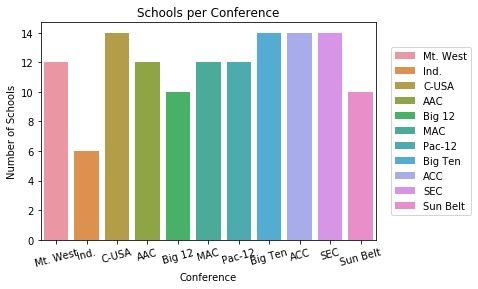

In [24]:
# Number of schools per conference. 
sns.countplot(x='Conference', data=df_final, hue='Conference', dodge=False)
_ = plt.xlabel('Conference')
_ = plt.ylabel('Number of Schools')
_ = plt.title('Schools per Conference')
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.xticks(rotation=15)
plt.show()

There are four conferences that have 14 schools, while only one - the Independent conference - has six schools. On average, there are 11.8 schools per conference. 

We want to predict how much a coach should be paid to take over a team. Our independent variable will then be the TotSchoolPayalPay variable. Of interest to us is how much each conference pays their coaches. We also want to know how winning affects wages, and if there's a difference between coaches that tend to win more at home than away or vice versa; and whether offense oriented teams tend to pay more than defense oriented teams.  
We also want to answer if there is a relationship between Points Per Season and Points Per Game - both scored and allowed - and School Pay. 

C:\Users\malon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


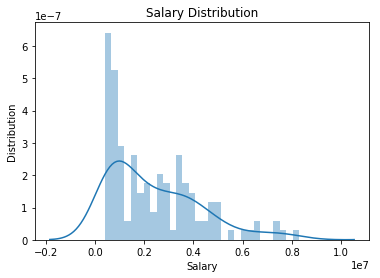

In [25]:
# Total Pay Distribution.
# We'll plot a histogram to gauge whether TotalPay follows a normal distribution or is skewed. 
sns.distplot(df_final.SchoolPay, bins = 30)
_ = plt.title('Salary Distribution')
_ = plt.xlabel('Salary')
_ = plt.ylabel('Distribution')
plt.show()

The data are skewed to the left with more coaches making less than 2,000,000 dollars. A very high wage when compared to the average person. 
Let's check salary distribution by conference as this might give us a better clue as to how coach salaries vary by conference and school. 

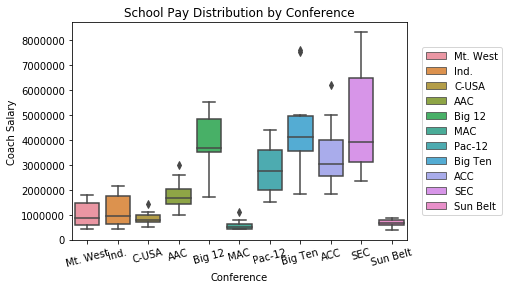

In [26]:
# Exploring the relationship between School Pay and Conference. 
sns.boxplot(x='Conference', y='SchoolPay', data=df_final, hue='Conference', dodge=False)
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.xlabel('Conference')
_ = plt.ylabel('Coach Salary')
_ = plt.title('School Pay Distribution by Conference')
_ = plt.xticks(rotation=15)
plt.show()

By far the SEC appears to have the best paying coaches. The Big Ten and Big 12 Conferences aren't far behind; while Mountain West, MAC, C-USA, Sun Belt, and Independent have the lowest paying coaches. We can assume, then, that Conference will be a driving factor in determining a coach's salary. 

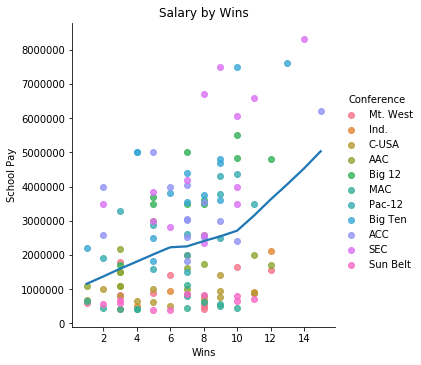

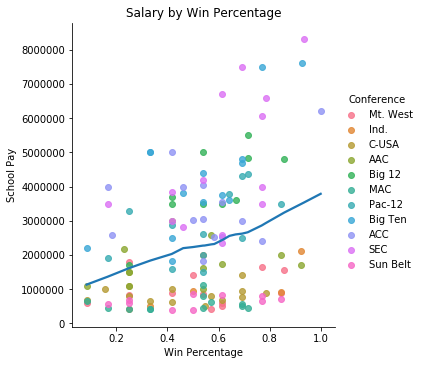

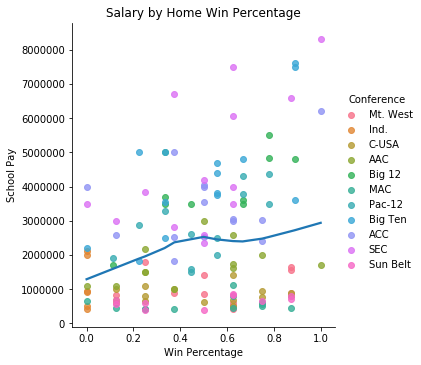

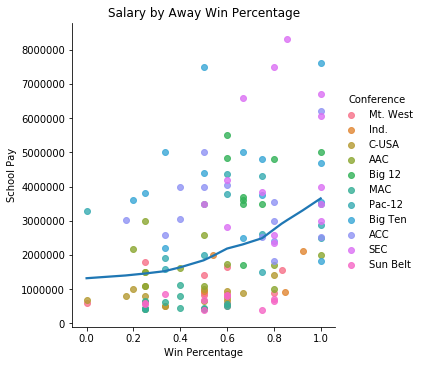

In [27]:
# Build an lm plot with loess regression.
# Lowess plot of total pay by number of conference wins
g = sns.lmplot(x='ConfW', y='SchoolPay', data=df_final, hue='Conference', fit_reg=False)
sns.regplot(x='ConfW', y='SchoolPay', data=df_final, scatter=False, ax=g.axes[0,0], lowess=True)
_ = plt.title('Salary by Wins')
_ = plt.xlabel('Wins')
_ = plt.ylabel('School Pay')
plt.show()

# Total pay by conference record
h = sns.lmplot(x='ConfRecord', y='SchoolPay', data=df_final, hue='Conference', fit_reg=False)
sns.regplot(x='ConfRecord', y='SchoolPay', data=df_final, scatter=False, ax=h.axes[0,0], lowess=True)
_ = plt.title('Salary by Win Percentage')
_ = plt.xlabel('Win Percentage')
_ = plt.ylabel('School Pay')
plt.show()

# Total pay by home record
i = sns.lmplot(x='HomeRecord', y='SchoolPay', data=df_final, hue='Conference', fit_reg=False)
sns.regplot(x='HomeRecord', y='SchoolPay', data=df_final, scatter=False, ax=i.axes[0,0], lowess=True)
_ = plt.title('Salary by Home Win Percentage')
_ = plt.xlabel('Win Percentage')
_ = plt.ylabel('School Pay')
plt.show()

# Total pay by away record
i = sns.lmplot(x='AwayRecord', y='SchoolPay', data=df_final, hue='Conference', fit_reg=False)
sns.regplot(x='AwayRecord', y='SchoolPay', data=df_final, scatter=False, ax=i.axes[0,0], lowess=True)
_ = plt.title('Salary by Away Win Percentage')
_ = plt.xlabel('Win Percentage')
_ = plt.ylabel('School Pay')
plt.show()

Looking at these graphs, it appears that the number of wins and road record are more important factors than winning at home or total win record. 
Having seen how winning games and record affects school pay, let's check how scoring affects coach wages. 

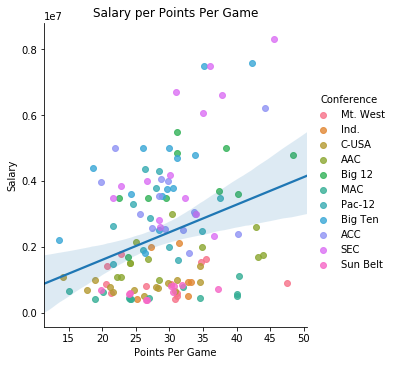

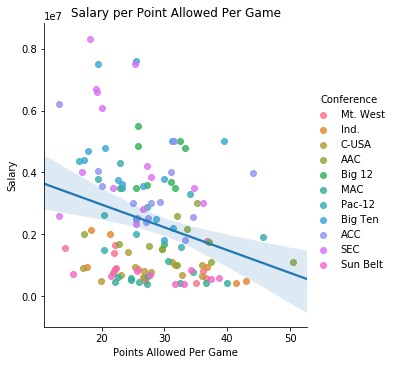

In [28]:
# Points Scored Per Game
g = sns.lmplot(x='PPG', y='SchoolPay', data=df_final, hue='Conference', fit_reg=False)
sns.regplot(x='PPG', y='SchoolPay', data=df_final, scatter=False, ax=g.axes[0,0])
_ = plt.xlabel('Points Per Game')
_ = plt.ylabel('Salary')
_ = plt.title('Salary per Points Per Game')
plt.show()

# Points Allowed Per Game
h = sns.lmplot(x='PAG', y='SchoolPay', data=df_final, hue='Conference', fit_reg=False)
sns.regplot(x='PAG', y='SchoolPay', data=df_final, scatter=False, ax=h.axes[0,0])
_ = plt.xlabel('Points Allowed Per Game')
_ = plt.ylabel('Salary')
_ = plt.title('Salary per Point Allowed Per Game')
plt.show()

As expected, there's a positive relationship between high scoring teams and school pay, while also being an inverse relationship between teams that allow opponents to score and school pay. This same pattern, ideally, should exist between offensive and defensive ratings. 

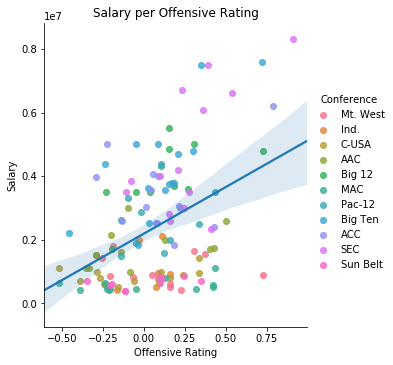

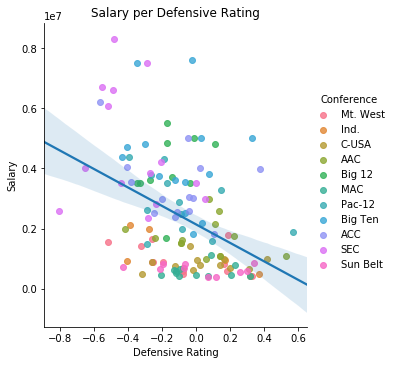

In [29]:
# Offensive and Defensive Ratings vs School Pay 
g = sns.lmplot(x='OffRat', y='SchoolPay', data=df_final, hue='Conference', fit_reg=False)
sns.regplot(x='OffRat', y='SchoolPay', data=df_final, scatter=False, ax=g.axes[0,0])
_ = plt.xlabel('Offensive Rating')
_ = plt.ylabel('Salary')
_ = plt.title('Salary per Offensive Rating')
plt.show()

# Points Allowed Per Game
h = sns.lmplot(x='DefRat', y='SchoolPay', data=df_final, hue='Conference', fit_reg=False)
sns.regplot(x='DefRat', y='SchoolPay', data=df_final, scatter=False, ax=h.axes[0,0])
_ = plt.xlabel('Defensive Rating')
_ = plt.ylabel('Salary')
_ = plt.title('Salary per Defensive Rating')
plt.show()

Indeed the relationship exists and is more pronounced than the relationship between school pay and scoring.   

Only thing left to do is check the relationship between school pay and stadium capacity, FSR, and GSR.

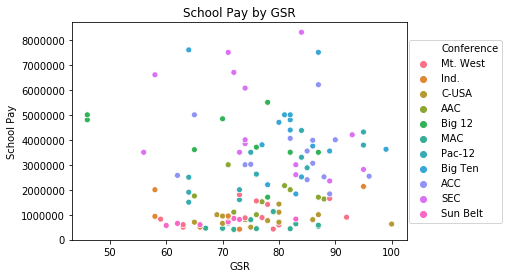

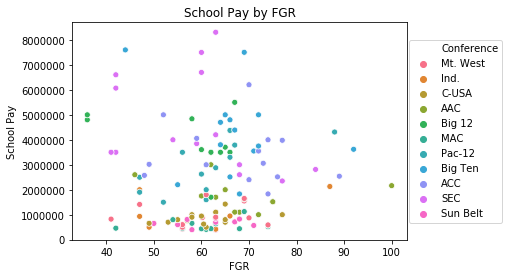

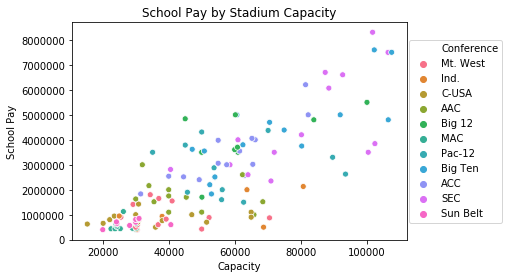

In [30]:
sns.scatterplot(x='GSR', y='SchoolPay', data=df_final, hue='Conference')
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.ylabel('School Pay')
_ = plt.title('School Pay by GSR')
plt.show()

sns.scatterplot(x='FGR', y='SchoolPay', data=df_final, hue='Conference')
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.ylabel('School Pay')
_ = plt.title('School Pay by FGR')
plt.show()

sns.scatterplot(x='Capacity', y='SchoolPay', data=df_final, hue='Conference')
_ = plt.legend(loc='center right', bbox_to_anchor=[1.3, 0.5])
_ = plt.ylabel('School Pay')
_ = plt.title('School Pay by Stadium Capacity')
plt.show()

GSR and FGR don't offer much insight into how high a coach's salary should be. Stadium capacity, however, does show a very obvious relationship. 

With these graphs, we have a close idea of what inputs our model should have: Conference, Wins, AwayRecord, PPG, PAG, GSR, FGR, Capacity, OffRat, and DefRat. Time to build the model! 

### Building the model

We'll first create a new data frame that will keep all the dependent and independent variables, along with a few other of interest. For any variable that isn't numeric, we'll run the LabelEncoder function to convert to a numeric feature.  
Once this is done, we'll create a feature_names array and set the target array. We'll then split the data into three sets:  
* Training set containing 67 percent of the data
* Test set containing 33 percent of the data
* Validation set that will contain only one observation: the Syracuse coach position. 

We'll test and adjust the model trying to produce the best model we can, wanting to find a negotiation range of salaries that we could ideally offer the Syracuse coach and negotiate from there. 

In [31]:
# Select the variables that will be used in the model, aswell as some additional variables that will be 
# kept to better identify the observations. 
df_model = df_final[['School', 'Conference', 'Coach', 'SchoolPay', 'ConfW', 'ConfL', 'PF', 'PA', 
                      'GSR', 'FGR', 'Capacity', 'AwayRecord', 'PPG', 'PAG', 'OffRat', 'DefRat']]

# Of these columns, the only column that is not numeric and will be used in the model is Conference. 
# We'll use the LabelEncoder function to convert it into numeric. 
le = LabelEncoder()
df_model.loc[:, 'Conference'] = le.fit_transform(df_model['Conference'])

df_model.head()

C:\Users\malon\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,School,Conference,Coach,SchoolPay,ConfW,ConfL,PF,PA,GSR,FGR,Capacity,AwayRecord,PPG,PAG,OffRat,DefRat
0,Air Force,7,Troy Calhoun,885000.0,5,7,363,309,77,60.181818,52237.0,0.500000,30.250000,25.750000,0.047693,-0.198309
1,Army,5,Jeff Monken,932521.0,11,2,426,230,58,47.000000,38000.0,0.846154,32.769231,17.692308,0.156743,-0.411283
2,Brigham Young,5,Kalani Sitake,2000000.0,7,6,354,278,58,47.000000,63725.0,0.538462,27.230769,21.384615,-0.032399,-0.280255
3,Rice,4,Mike Bloomgren,1000000.0,2,11,246,468,87,77.000000,47000.0,0.200000,18.923077,36.000000,-0.286871,0.416824
4,Southern Methodist,0,Sonny Dykes,3000000.0,5,7,365,423,71,62.000000,32000.0,0.250000,30.416667,35.250000,-0.098642,0.074716


In [32]:
# Select the feature_names variables and the target variable. This will facilitate the creation of the 
# training and testing sets. 
feature_names = ['Conference','ConfW','ConfL','PF','PA','GSR','FGR', 'Capacity','AwayRecord','PPG',
                 'PAG','OffRat', 'DefRat']
target_name = ['SchoolPay']

# We'll now take out the validation set. 
validation = df_model[df_model['School']=='Syracuse']
df_model2 = df_model[df_model['School']!='Syracuse']

# Build training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_model2[feature_names], df_model2[target_name], 
                                                   test_size=0.33, random_state=42)

In [33]:
# Builds the model
model = sm.OLS(y_train, X_train)

# Fits the model
results = model.fit()

# Model results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     60.88
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           8.95e-34
Time:                        21:37:10   Log-Likelihood:                -1304.2
No. Observations:                  86   AIC:                             2634.
Df Residuals:                      73   BIC:                             2666.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Conference -1.697e+05   4.43e+04     -3.833      0.0

The model is very good at predicting the total salary for a coach, having an adjusted R-squared of 0.901. Quick takeaways that we can take from this model: GSR, FGR, ConfW, ConfL, PF, PA, and AwayRecord aren't significant predictors for determining a coach's salary. GSR and FSR make sense as guaranteeing that student-athletes graduate is not part of a coach's job description. Therefore, they shouldn't affect his salary.  
ConfW, ConfL, PF, PA, and AwayRecord, on the other hand, are more confusing as any person would think that these are results that a coach can be held responsible for and, as such, should be reviewed as a part of their salary negotiations.  
Let's use this model to try and predict what the test set's salaries should be.  

Model 1 R-squared:  0.7083178795064988
Model 1 RMSE:  879807.4846923787
Model 1 MAE:  713092.055269739


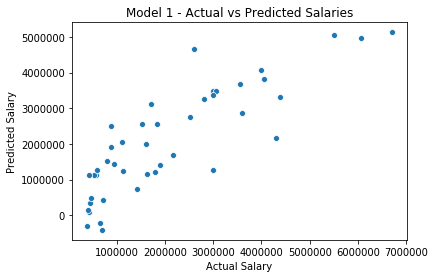

In [34]:
# Predict salaries for first model
prediction = results.predict(X_test)
prediction = pd.Series(prediction)

prediction_results = pd.concat([y_test, prediction], axis=1, ignore_index=False)
prediction_results.columns = ['SchoolPay Actual', 'SchoolPay Predicted']

print('Model 1 R-squared: ', r2_score(prediction_results['SchoolPay Actual'], 
                                      prediction_results['SchoolPay Predicted']))
print('Model 1 RMSE: ', np.sqrt(mean_squared_error(prediction_results['SchoolPay Actual'], 
                                                   prediction_results['SchoolPay Predicted'])))
print('Model 1 MAE: ', mean_absolute_error(prediction_results['SchoolPay Actual'], 
                                           prediction_results['SchoolPay Predicted']))
sns.scatterplot(x='SchoolPay Actual', y='SchoolPay Predicted', data=prediction_results)
_ = plt.title('Model 1 - Actual vs Predicted Salaries')
_ = plt.xlabel('Actual Salary')
_ = plt.ylabel('Predicted Salary')
plt.show()

Looking at the R-squared value for the test set, it appears that this model suffers from a bit of overfitting. Similarly, we can see in the plot that we have three cases where the model predicts a negative salary for the coaches.  
We'll build a second model, removing GSR and FSR from the input variable since they do not add significance to the first model, and compare the new results. 

In [35]:
# We'll remove GSR and FSR from the input variables as they are not significant to the model. 

# Select the feature_names variables and the target variable. This will facilitate the creation of the 
# training and testing sets. 
feature_names2 = ['Conference','ConfW','ConfL','PF','PA','Capacity','AwayRecord','PPG','PAG',
                 'OffRat','DefRat']
target_name = ['SchoolPay']

# Build training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_model2[feature_names2], df_model2[target_name], 
                                                   test_size=0.33, random_state=42)

In [36]:
# Builds the model
model2 = sm.OLS(y_train2, X_train2)

# Fits the model
results2 = model2.fit()

# Model results
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     73.40
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           1.53e-35
Time:                        21:37:11   Log-Likelihood:                -1304.5
No. Observations:                  86   AIC:                             2631.
Df Residuals:                      75   BIC:                             2658.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Conference -1.772e+05   4.22e+04     -4.195      0.0

The second model show slight improvement on the training set, increasing the R-squared value by 0.002. Similarly, we can see that the p-values for ConfW and ConfL have decreased but, like PF, PA, and AwayRecord, they are still not significant enough.  
Let's run this model on the test set. 

Model 2 R-squared:  0.7123272089277433
Model 2 RMSE:  873739.8455480641
Model 2 MAE:  697237.8922723269


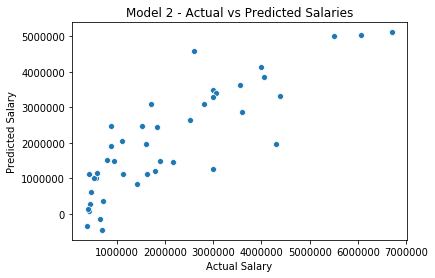

In [37]:
# Predict salaries for second model
prediction2 = results2.predict(X_test2)
prediction2 = pd.Series(prediction2)

prediction_results2 = pd.concat([y_test2, prediction2], axis=1, ignore_index=False)
prediction_results2.columns = ['SchoolPay Actual', 'SchoolPay Predicted']

print('Model 2 R-squared: ', r2_score(prediction_results2['SchoolPay Actual'], 
                                      prediction_results2['SchoolPay Predicted']))
print('Model 2 RMSE: ', np.sqrt(mean_squared_error(prediction_results2['SchoolPay Actual'], 
                                                   prediction_results2['SchoolPay Predicted'])))
print('Model 2 MAE: ', mean_absolute_error(prediction_results2['SchoolPay Actual'], 
                                           prediction_results2['SchoolPay Predicted']))
sns.scatterplot(x='SchoolPay Actual', y='SchoolPay Predicted', data=prediction_results2)
_ = plt.title('Model 2 - Actual vs Predicted Salaries')
_ = plt.xlabel('Actual Salary')
_ = plt.ylabel('Predicted Salary')
plt.show()

The second model also improves on all three metrics albeit not by much. The R-squared value increases from 0.708 to 0.712. Similarly, both the RMSE and MAE suffer a drop moving from 879,402 to 873,265 and 705,242 to 689,589. Furthermore, the model still predicts three coaches to have a salary below zero, something which can't be right.  
We'll build a third model, this time removing the remaining variables that feature a p-value greater than 10 percent. 

In [66]:
# Remove ConfW, ConfL, PF, PA, and AwayRecord from the input variables. 

# Select the feature_names variables and the target variable. This will facilitate the creation of the 
# training and testing sets. 
feature_names3 = ['Conference','Capacity','PPG','PAG','OffRat','DefRat']
target_name = ['SchoolPay']

# Build training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_model2[feature_names3], df_model2[target_name], 
                                                   test_size=0.33, random_state=42)

In [39]:
# Builds the model
model3 = sm.OLS(y_train3, X_train3)

# Fits the model
results3 = model3.fit()

# Model results
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     136.5
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           6.76e-40
Time:                        21:37:11   Log-Likelihood:                -1306.4
No. Observations:                  86   AIC:                             2625.
Df Residuals:                      80   BIC:                             2640.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Conference -1.471e+05   3.57e+04     -4.125      0.0

All the variables are significant for this model as we can see by the p-values. Similarly, the model has improved it's R-squared to 0.904, greater than the previous two models.  
Let's validate these results with the test set. 

Model 3 R-squared:  0.7261589247082276
Model 3 RMSE:  852475.7697656885
Model 3 MAE:  656450.2533737982


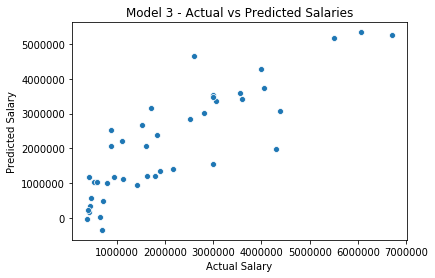

In [40]:
# Predict salaries for third model
prediction3 = results3.predict(X_test3)
prediction3 = pd.Series(prediction3)

prediction_results3 = pd.concat([y_test3, prediction3], axis=1, ignore_index=False)
prediction_results3.columns = ['SchoolPay Actual', 'SchoolPay Predicted']

print('Model 3 R-squared: ', r2_score(prediction_results3['SchoolPay Actual'], 
                                      prediction_results3['SchoolPay Predicted']))
print('Model 3 RMSE: ', np.sqrt(mean_squared_error(prediction_results3['SchoolPay Actual'], 
                                                   prediction_results3['SchoolPay Predicted'])))
print('Model 3 MAE: ', mean_absolute_error(prediction_results3['SchoolPay Actual'], 
                                           prediction_results3['SchoolPay Predicted']))
sns.scatterplot(x='SchoolPay Actual', y='SchoolPay Predicted', data=prediction_results3)
_ = plt.title('Model 3 - Actual vs Predicted Salaries')
_ = plt.xlabel('Actual Salary')
_ = plt.ylabel('Predicted Salary')
plt.show()

We still have overfitting but the overall results have vastly improved. We can see that there are still coaches featuring a negative salary, but these are closer to zero than in the previous model iterations.  
We'll now run the three models with the validation set, that is, try and predict what the Syracuse coach's salary should be. 

In [41]:
valid_predict = results.predict(validation[feature_names])
valid_predict2 = results2.predict(validation[feature_names2])
valid_predict3 = results3.predict(validation[feature_names3])

# Print results 
print('Actual Salary: ', validation['SchoolPay'])
print('Model 1 Prediction: %s' % np.round(valid_predict, 2))
print('Model 2 Prediction: %s' % np.round(valid_predict2, 2))
print('Model 3 Prediction: %s' % np.round(valid_predict3, 2))

Actual Salary:  34    2401206.0
Name: SchoolPay, dtype: float64
Model 1 Prediction: 34    3355885.81
dtype: float64
Model 2 Prediction: 34    3291394.28
dtype: float64
Model 3 Prediction: 34    3385218.16
dtype: float64


### Evaluating results

Of the three models created, the third model outperforms the first two on all three counts: a lower-difference between training and testing error, a lower RMSE, and a lower MAE. However, despite having a lower error rate between the training and testing set, all three models suffer from overfitting. This can be improved on but would require that we test predicting each coaches salary using more data or more input variables. Nevertheless, as far as immediate results concern, the third model serves as our best estimate.  
  
As to the Syracuse coache's salary, he is currently paid 2,401,206 dollars. Despite being the least robust of the three models, the first model gives a middle ground salary between the second and third models, predicting that the coach should be earining 3,355,885 dollars given his current results. The second model is more conservative, predicting that the coach should be earning 3,291,394 dollars, while the third model predicts 3,385,218 dollars.  
However, we should not stick strictly to any of these answers. Instead, these figures should give us a baseline on which to negotiate; the numbers returned should serve as soft or hard caps on the coach's salary, a number that must not be passed, rather than a first immediate figure that should be paid. 

### Final thoughts and recommendations

Given the current salary and the coach's record with the school, I recommend the coach's current salary be used as a starting point for current negotiations. From there, a salary more suited to his ideal earnings can be discussed until an agreement is reached. I recommend using the result from the first model as a soft ceiling and the result from the second model as a hard ceiling to what the coach should be earning. Any amount beyond that could be considered as overpaying for the coach's services.  

As to the model itself, it would be reasonable to create and run a third and fourth model that could be, potentially, more accurate, giving another bargaining position that may indicate whether the coach's current salary is enough or should we be offering him more. 

#### Big Ten Big 12 
What would the coach's salary be if he coached in the Big 12 or Big Ten. 

In [42]:
validation

,School,Conference,Coach,SchoolPay,ConfW,ConfL,PF,PA,GSR,FGR,Capacity,AwayRecord,PPG,PAG,OffRat,DefRat
34,Syracuse,1,Dino Babers,2401206.0,10,3,523,351,85,70.0,49250.0,0.8,40.230769,27.0,0.428726,-0.128464


In [55]:
validationBig12 = validation

# Big 12 == 2; Big Ten == 3
validationBig12.loc[:, 'Conference'] = 2 

# Run model 3 for both Big 12 and Big Ten
salaryBig12 = results3.predict(validationBig12[feature_names3])

print('Big 12: %d' % salaryBig12)

Big 12: 3238164


In [56]:
validationBigTen = validation

# Big 12 == 2; Big Ten == 3
validationBigTen.loc[:, 'Conference'] = 3

# Run model 3 for both Big 12 and Big Ten
salaryBigTen = results3.predict(validationBigTen[feature_names3])

print('Big Ten: %d' % salaryBigTen)

Big Ten: 3091111


#### Bonus question

In [76]:
# Build a Linear Mixed Effect Model
mlm_model = sm.MixedLM(y_train3, X_train3, groups=X_train3["Conference"])
mlm_results = mlm_model.fit()
print(mlm_results.summary())

                     Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      SchoolPay        
No. Observations:       86           Method:                  REML             
No. Groups:             11           Scale:                   725240309925.6888
Min. group size:        5            Likelihood:              -1238.0001       
Max. group size:        14           Converged:               Yes              
Mean group size:        7.8                                                    
-------------------------------------------------------------------------------
                Coef.         Std.Err.    z    P>|z|     [0.025       0.975]   
-------------------------------------------------------------------------------
Conference      -134082.867   63193.031 -2.122 0.034   -257938.932   -10226.801
Capacity             31.444       5.887  5.341 0.000        19.906       42.983
PPG             -218801.237   64122.654 -3.412 0.001   -34447

LME R-squared:  0.7259527096959049
LME RMSE:  852796.6862288424
LME MAE:  672847.6404610395


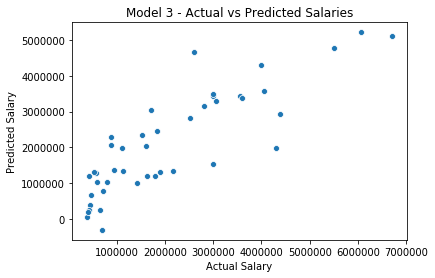

In [74]:
# Predict salaries for the linear mixed effect model
mlm_prediction = mlm_results.predict(X_test3)
mlm_prediction = pd.Series(mlm_prediction)

mlm_prediction = pd.concat([y_test3, mlm_prediction], axis=1, ignore_index=False)
mlm_prediction.columns = ['SchoolPay Actual', 'SchoolPay Predicted']

print('LME R-squared: ', r2_score(mlm_prediction['SchoolPay Actual'], 
                                      mlm_prediction['SchoolPay Predicted']))
print('LME RMSE: ', np.sqrt(mean_squared_error(mlm_prediction['SchoolPay Actual'], 
                                                   mlm_prediction['SchoolPay Predicted'])))
print('LME MAE: ', mean_absolute_error(mlm_prediction['SchoolPay Actual'], 
                                           mlm_prediction['SchoolPay Predicted']))
sns.scatterplot(x='SchoolPay Actual', y='SchoolPay Predicted', data=mlm_prediction)
_ = plt.title('Model 3 - Actual vs Predicted Salaries')
_ = plt.xlabel('Actual Salary')
_ = plt.ylabel('Predicted Salary')
plt.show()

#### Double Bonus question

In [58]:
# Remove Conference from the third model

# Select the feature_names variables and the target variable. This will facilitate the creation of the 
# training and testing sets. 
feature_names4 = ['Capacity','PPG','PAG','OffRat','DefRat']
target_name = ['SchoolPay']

# Build training and testing sets
X_train4, X_test4, y_train4, y_test4 = train_test_split(df_model2[feature_names4], df_model2[target_name], 
                                                   test_size=0.33, random_state=42)

# Builds the model
model4 = sm.OLS(y_train4, X_train4)

# Fits the model
results4 = model4.fit()

# Model results
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     133.9
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           1.19e-37
Time:                        22:14:31   Log-Likelihood:                -1314.7
No. Observations:                  86   AIC:                             2639.
Df Residuals:                      81   BIC:                             2652.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Capacity      42.9265      6.426      6.680      0.0

Model 4 R-squared:  0.7148199402899234
Model 4 RMSE:  869946.0605354237
Model 4 MAE:  659337.6361660996


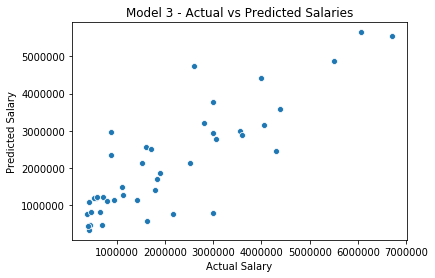

In [59]:
# Predict salaries for third model
prediction4 = results4.predict(X_test4)
prediction4 = pd.Series(prediction4)

prediction_results4 = pd.concat([y_test4, prediction4], axis=1, ignore_index=False)
prediction_results4.columns = ['SchoolPay Actual', 'SchoolPay Predicted']

print('Model 4 R-squared: ', r2_score(prediction_results4['SchoolPay Actual'], 
                                      prediction_results4['SchoolPay Predicted']))
print('Model 4 RMSE: ', np.sqrt(mean_squared_error(prediction_results4['SchoolPay Actual'], 
                                                   prediction_results4['SchoolPay Predicted'])))
print('Model 4 MAE: ', mean_absolute_error(prediction_results4['SchoolPay Actual'], 
                                           prediction_results4['SchoolPay Predicted']))
sns.scatterplot(x='SchoolPay Actual', y='SchoolPay Predicted', data=prediction_results4)
_ = plt.title('Model 3 - Actual vs Predicted Salaries')
_ = plt.xlabel('Actual Salary')
_ = plt.ylabel('Predicted Salary')
plt.show()